$$
H = \frac{|p|^2}2 + \gamma \sin(\theta t) s + \frac{\alpha}{|q|}
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate as si

plt.style.use("fast")  # alt: 'seaborn-white'

# plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
class TimePerturbedKepler:
    def __init__(self, gamma, theta, alpha):
        self.θ = theta
        self.α = alpha
        self.γ = gamma

    def V(self, q, t):
        return self.α / np.linalg.norm(q)

    def Vq(self, q, t):
        return -q * self.α / np.linalg.norm(q) ** 3

    def f(self, t):
        return self.γ * np.sin(self.θ * t)

    def F(self, z, t):
        return self.f(t) * z

    def Fz(self, z, t):
        return self.f(t)

    def lag(self, q, v, z, t):
        return 0.5 * np.linalg.norm(v) ** 2 - self.V(q, t) - self.f(t) * z

    def lagq(self, q, v, z, t):
        return -self.Vq(q, t)

    def lagv(self, q, v, z, t):
        return v

    def lagz(self, q, v, z, t):
        return -self.Fz(z, t)

    def energy(self, p, q, z, t):
        return 0.5 * np.linalg.norm(p) ** 2 + self.f(t) * z + self.V(q, t)

In [4]:
def rk4s(system, init, tspan):
    n = len(init)

    def derivs(x, t):
        p = x[: (n - 1) // 2]
        q = x[(n - 1) // 2 : n - 1]
        s = x[-1]
        dp = -system.Vq(q, t) - system.f(t) * p
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])

    return rk4(derivs, init, tspan)


def adaptive(system, init, tspan):
    t_span = (tspan[0], tspan[-1])
    n = len(init)

    def derivs(t, x):
        p = x[: (n - 1) // 2]
        q = x[(n - 1) // 2 : n - 1]
        s = x[-1]
        dp = -system.Vq(q, t) - system.f(t) * p
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])

    return si.solve_ivp(
        derivs, t_span, init, t_eval=tspan, method="Radau", dense_output=True
    )

In [5]:
e = 0.2
init_ecc = lambda e: [
    np.array([1.0 - e, 0.0]),
    np.array([0.0, np.sqrt((1 + e) / (1 - e))]),
    np.array([0.0]),
]
init = init_ecc(e)

energy = lambda pq, z, tspan: np.array(
    [tpk.energy(pq[:, 0][i], pq[:, 1][i], z[i], t) for i, t in enumerate(tspan)]
)
save = True

## RK4 comparisons

In [6]:
def long_time_plot(
    system,
    init,
    dt,
    tf,
    file_name,
    adaptive=False,
    save=True,
    solutions=False,
    sixth=False,
    rasterized=False,
):
    tspan = np.arange(0.0, tf, dt)
    p0, q0, s0 = init
    fig = plt.figure(figsize=(16, 4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)

    solh, solsh, _ = ic.integrate(ic.step1l, system, tspan, p0, q0, s0)
    solv, solsv, _ = ic.integrate(ic.variational_step, system, tspan, p0, q0, s0)
    solrk = rk4s(system, np.concatenate([p0, q0, s0]), tspan)
    if adaptive:
        r = adaptive(system, np.concatenate([p0, q0, s0]), tspan)
    if sixth:
        sol6, sols6, _ = ic.integrate(ic.step6, system, tspan, p0, q0, s0)

    axo = fig.add_subplot(gs[0, 0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(
        solrk[:, 2],
        solrk[:, 3],
        ":",
        linewidth=0.5,
        c="C2",
        label="Runge–Kutta 4th",
        rasterized=rasterized,
    )

    axo.plot(
        solh[:, 1, 0],
        solh[:, 1, 1],
        c="C0",
        linewidth=0.5,
        label="CHI 2nd",
        rasterized=rasterized,
    )

    axo.plot(
        solv[:, 1, 0],
        solv[:, 1, 1],
        c="C1",
        linewidth=0.5,
        label="CVI 2nd",
        rasterized=rasterized,
    )

    if adaptive:
        axo.plot(
            r.y[:, 2],
            r.y[:, 3],
            ":",
            linewidth=0.5,
            c="C3",
            label="Adaptive",
            rasterized=rasterized,
        )

    if sixth:
        axo.plot(
            sol6[:, 1, 0],
            sol6[:, 1, 1],
            c="C4" if adaptive else "C3",
            linewidth=0.5,
            label="CHI 6th",
            rasterized=rasterized,
        )

    axo.scatter(0, 0)

    axo.set_aspect("equal", adjustable="box")

    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$q_1$")
    axo.set_ylabel("$q_2$")

    # axo.legend(loc='lower left')

    axe = fig.add_subplot(gs[0, 1:])
    axe.set_title("Distance From the Center")

    axe.plot(
        tspan,
        np.linalg.norm(solh[:, 1], axis=1),
        linewidth=0.5,
        label="CHI 2nd",
        rasterized=rasterized,
    )
    axe.plot(
        tspan,
        np.linalg.norm(solv[:, 1], axis=1),
        linewidth=0.5,
        label="CVI 2nd",
        rasterized=rasterized,
    )

    axe.plot(tspan, np.linalg.norm(solrk[:, 2:4], axis=1), linewidth=0.5, label="Runge–Kutta 4th")

    if adaptive:
        axe.plot(
            tspan,
            np.linalg.norm(r.y.T[:, 2:4], axis=1),
            linewidth=0.5,
            label="Reference",
            rasterized=rasterized,
        )

    if sixth:
        axe.plot(
            tspan,
            np.linalg.norm(sol6[:, 1], axis=1),
            linewidth=0.5,
            label="CHI 6th",
            rasterized=rasterized,
        )

    axe.set_ylim(0, 4)
    axe.legend(loc="upper right")

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|q\|$")

    if save:
        fig.savefig(f"images/{file_name}.pdf", bbox_inches="tight")
    plt.show()

    if solutions:
        return (
            [solh, solsh],
            [solv, solsv],
            [np.array([solrk[:, 0:2], solrk[:, 2:4]]), solrk[:, 4]],
        )

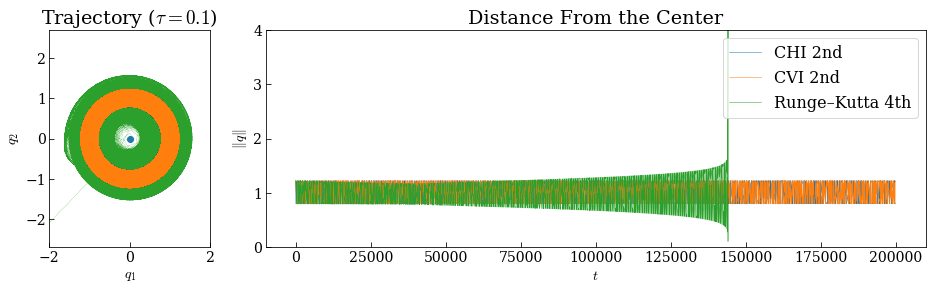

In [7]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.1
tf = 200000

long_time_plot(tpk, init, dt, tf, "TPK01", rasterized=True)

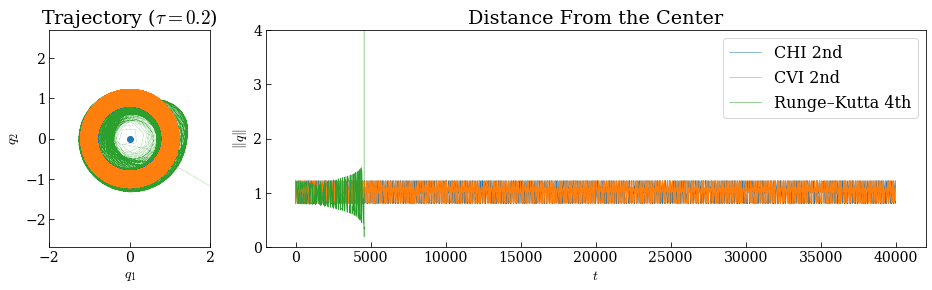

In [8]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.2
tf = 40000

long_time_plot(tpk, init, dt, tf, "TPK02")

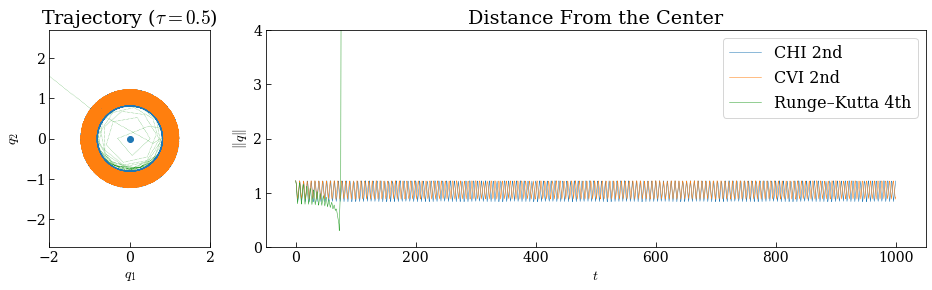

In [9]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.5
tf = 1000

long_time_plot(tpk, init, dt, tf, "TPK05")

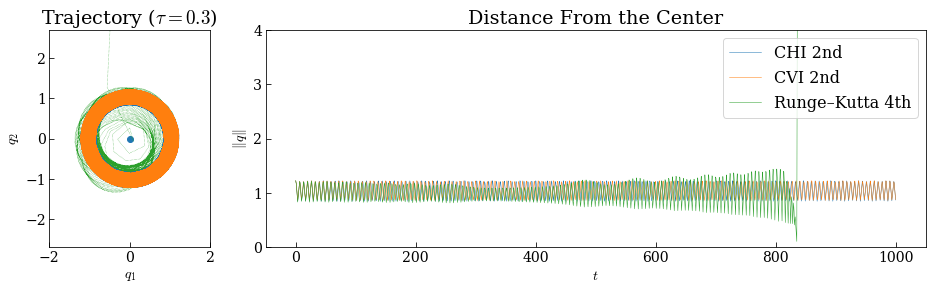

In [10]:
tpk = TimePerturbedKepler(-0.05, np.pi, -1)
dt = 0.3
tf = 1000

long_time_plot(tpk, init, dt, tf, "TPK03")

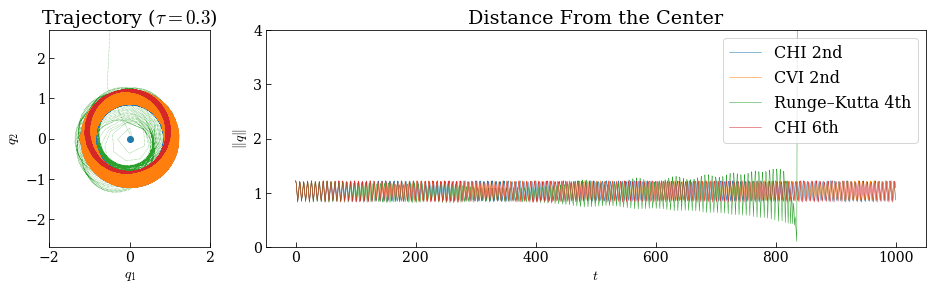

In [11]:
tpk = TimePerturbedKepler(-0.05, np.pi, -1)
dt = 0.3
tf = 1000

long_time_plot(tpk, init, dt, tf, "TPK03prec", sixth=True)